# Welcome to our CIS 519 final project! 
## In this notebook, our goal is to apply ML/DL models to the dataset and extract the most supportable phrase or word of a given text according to an associated sentiment. Let :)

# Setup


## **import libraries**

In [ ]:
#@title 
## Data preprocessing part
import pandas as pd
import re
import string
import numpy as np
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

## Seed setup
# seed = 2022
# random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.cuda.manual_seed(seed)

## Device detection
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


##**Glove embeddings**

In [ ]:
!wget -nc https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!ls -lat

--2022-04-26 00:33:11--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-04-26 00:33:11--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  5.11MB/s    in 6m 51s  

2022-04-26 00:40:02 (5.05 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     
total 

In [ ]:
glove_file = "glove.840B.300d.txt"

# **1. Data Analysis**

## **1.1 Data overview**

First lets All data is stored in train.csv file with 27481 rows.

The source of the data is from kaggle comepetitions: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv 

**Columns**

- **textID** - unique ID for each piece of the text
- **text** - the text of the tweet
- **sentiment** - the general sentiment of the tweet
- **selected_text** - the text that supports the tweet's sentiment


In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
data.shape

(27481, 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


# **2. Data preprocessing**

In [ ]:
#@title Helper functions
## Data preprocessing part
def remove_hyperlinks(text):
  hyperlinkfree=re.sub('https?://\S+|www\.\S+', '', text)
  return hyperlinkfree

def remove(text):
  text=re.sub('\S*\d\S*',' ',text) #Removing Numbers
  text=re.sub('<.*?>+',' ',text)   #Removing Angular Brackets
  text=re.sub('\[.*?\]',' ',text)  #Removing Square Brackets
  text=re.sub('\n',' ',text)       #Removing '\n' character 
  text=re.sub('\*+','<ABUSE>',text) #Replacing **** by ABUSE word
  return text

def remove_punctuation(text):
  punctuationfree="".join([i for i in text if i not in string.punctuation])
  return punctuationfree

def wrong_words(text,selected):
  words=[]
  text = str(text)
  selected= str(selected)
  text=text.split()
  selected=selected.split()
  for i in selected:
    if i not in text:
      words.append(i)
  if len(words)>0:
    return " ".join(words)
  else:
    return '++++'

def remove_text(x):
  selected=x[0]
  spelling=x[1]
  selected=selected.split()
  selected.remove(spelling) 
  return " ".join(selected)

def matching_55(x):
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>55): 
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected) 

def matching_35(x):
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>35):
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected)

def start_index(x):
  text=x[0]
  selected=x[1]
  text=text.split()
  selected=selected.split()
  word=selected[0]
  index=text.index(word)
  return index

def end_index(x):
  text=x[0]
  selected=x[1]
  start_index=x[2] 
  text=text.split()
  selected= selected.split()
  word=selected[-1]
  try:
    index=text.index(word,start_index)
  except:
    index=text.index(word)
  return index

def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  # nothing output = output all
  if len(index) == 0:
    pred = text
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

def jaccard(str1,str2): 
  a=set(str1.lower().split()) 
  b=set(str2.lower().split())
  c=a.intersection(b)

  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
data.dropna(inplace=True)

In [ ]:
# lower case
data['text']= data['text'].apply(lambda x: x.lower() if type(x) == str else x)
data['selected_text']= data['selected_text'].apply(lambda x: x.lower() if type(x) == str else x)

In [ ]:
# remove hyperlink
data['text']=data['text'].apply(lambda x:remove_hyperlinks(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove_hyperlinks(x) if type(x) == str else x)

In [ ]:
#
data['text']=data['text'].apply(lambda x:remove(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove(x) if type(x) == str else x)

In [ ]:
data['text']=data['text'].apply(lambda x:remove_punctuation(x) if type(x) == str else x)
data['selected_text']=data['selected_text'].apply(lambda x:remove_punctuation(x) if type(x) == str else x)

In [ ]:
data.drop(data[data["text"]==' '].index,inplace=True)
data.drop(data[data["selected_text"]==' '].index,inplace=True)

In [ ]:
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

In [ ]:
data['selected_text']=data[['selected_text','spelling']].apply(lambda x: remove_text(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

In [ ]:
data['selected_text']=data.apply(lambda x: x['text'] if ( (x['spelling']!='++++') & (x['sentiment']=='neutral') ) else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
# data.loc[(data['spelling']!='++++') & (data['sentiment']=='neutral')].head()

In [ ]:
data['selected_text']=data[['text','selected_text','spelling']].apply(lambda x: matching_55(x) if x['spelling']!='++++'  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

In [ ]:
data['selected_text']=data[['selected_text','spelling']].apply(lambda x: remove_text(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

In [ ]:
data['selected_text']=data[['text','selected_text','spelling']].apply(lambda x: matching_35(x) if x['spelling']!='++++'  else x['selected_text'],axis=1)
data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)
# data.loc[(data['spelling']!='++++') & (data['sentiment']=='positive')]

In [ ]:
# negative
data.loc[2398].selected_text='did miss you'
data.loc[6113].selected_text='these dogs are going to die if somebody doesnt save them'
data.loc[9817].text='following and followers not nice'
data.loc[13637].selected_text='hates me  cryyyy'
data.loc[14839].selected_text='boring but had to eat nonetheless'
data.loc[16201].selected_text='off to work'
data.loc[25293].selected_text='at the bottom of the totem pole'

# positive
data.loc[1588].selected_text='woooooooooo'
data.loc[10521].selected_text='greetings'
data.loc[7410].text='im in the room im watching the hannah movie with mom she said this film very great'

data['spelling']=data.apply(lambda x: wrong_words(x.text,x.selected_text),axis=1)

data[data['spelling'].apply(lambda x: len(x))==1]

,textID,text,selected_text,sentiment,spelling


In [ ]:
data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

# drop text & selected_text ==''
data.drop(8727,inplace=True)
data.drop(25996,inplace=True)

data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

In [ ]:
data['start_index']=data[['text','selected_text']].apply(lambda x: start_index(x),axis=1)
data['end_index']=data[['text','selected_text','start_index']].apply(lambda x: end_index(x),axis=1)

data= data[data.start_index <= data.end_index]

data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data.shape

(27381, 7)

In [ ]:
# from google.colab import files

# data.to_csv('output.csv', encoding = 'utf-8-sig') 
# files.download('output.csv')

# **3.Sentiment Analysis using LSTM & Bi-LSTM**





###**import** 

In [ ]:
## Training part
import tensorflow as tf
!pip install --upgrade tensorflow
from sklearn.model_selection import train_test_split

### **Splitting dataset & Tokenization**

In [ ]:
def one_hot_coding(raw_data, max_len_text):
    # Get X, y for training
    X=raw_data[['textID','text','selected_text','sentiment']]

    y=np.zeros((raw_data.shape[0],max_len_text+1))
    for i in range(raw_data.shape[0]):
      start=raw_data['start_index'][i]
      end=raw_data['end_index'][i]
      y[i][start:end+1]=1

    return X, y

In [ ]:
# splitting data into train &test dataset
train = data.sample(frac=0.85, random_state=200)
test = data.merge(train, how='left', indicator=True)
test = test[test['_merge'] == 'left_only']

train.reset_index(inplace = True)
test.reset_index(inplace = True)

text_split=data['text'].apply(lambda x: len(str(x).split())).tolist()
max_len_text = max(text_split)

# X_train.shape (23274, 4), X_test.shape (4107, 4)
# y_train.shape (23274, 33), y_test.shape (4107, 33)
X_train, y_train = one_hot_coding(train, max_len_text)
X_test, y_test = one_hot_coding(test, max_len_text)
# X_test = X_test[['textID','text','sentiment']]

# Split into training data & validation data
## X_train shape  (21877, 4)  , X_valid shape  (1397, 4)
## y_train shape  (21877, 33) ,  y_valid shape  (1397, 33)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.06, random_state=42)

In [ ]:
# Add dims (y shape)
y_train=np.expand_dims(y_train,-1)
y_valid=np.expand_dims(y_valid,-1)
# transfer text & sentiment into list of strings
train_text=X_train['text'].values
valid_text=X_valid['text'].values
train_sentiment=X_train['sentiment'].values
valid_sentiment=X_valid['sentiment'].values

In [ ]:
# Keras tokenizer( text)
token1= tf.keras.preprocessing.text.Tokenizer(num_words=None)

token1.fit_on_texts(list(train_text))
train_text=token1.texts_to_sequences(train_text)
valid_text=token1.texts_to_sequences(valid_text)

# Keras tokenizer( sentiment)
token2= tf.keras.preprocessing.text.Tokenizer(num_words=None)

token2.fit_on_texts(list(train_sentiment))
train_sentiment=token2.texts_to_sequences(train_sentiment)
valid_sentiment=token2.texts_to_sequences(valid_sentiment)

# Pads each sequence to the same length
max_len_text=32
train_text= tf.keras.preprocessing.sequence.pad_sequences(train_text,maxlen=max_len_text,padding='post')
valid_text= tf.keras.preprocessing.sequence.pad_sequences(valid_text,maxlen=max_len_text,padding='post')
max_len_sentiment=1
train_sentiment= tf.keras.preprocessing.sequence.pad_sequences(train_sentiment,maxlen=max_len_sentiment,padding='post')
valid_sentiment= tf.keras.preprocessing.sequence.pad_sequences(valid_sentiment,maxlen=max_len_sentiment,padding='post')

word_index_text=token1.word_index
word_index_sentiment=token2.word_index

In [ ]:
# test data
test_text = test['text'].values
test_sentiment = test['sentiment'].values

test_text=token1.texts_to_sequences(test_text)
test_text=tf.keras.preprocessing.sequence.pad_sequences(test_text,maxlen=max_len_text,padding='post')

test_sentiment=token2.texts_to_sequences(test_sentiment)
test_sentiment=tf.keras.preprocessing.sequence.pad_sequences(test_sentiment,maxlen=max_len_sentiment,padding='post')

### **Embeddings**

In [ ]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
with open('/content/glove.840B.300d.txt') as f:
  for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

2196017it [04:24, 8295.92it/s]

Found 2196016 word vectors.


In [ ]:
# Use pre-trained word embedding 
# create  an embedding matrix for text
embedding_matrix_text=np.zeros((len(word_index_text) + 1, 300))
for word, i in word_index_text.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None: # words not found in embedding index will be all-zeros.
        embedding_matrix_text[i]=embedding_vector
 
# create  an embedding matrix for sentiment
embedding_matrix_sentiment=np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in word_index_sentiment.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i]=embedding_vector

## **3.1 LSTM architecture**

In [ ]:
# LSTM model part
from tensorflow.keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import jaccard_score
from tensorflow.keras import optimizers
from keras.regularizers import l2


In [ ]:
text_input=layers.Input(shape=(max_len_text,))
text_embedding = layers.Embedding(
    len(word_index_text)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_text),
    mask_zero=True,
    trainable=False,
    input_length=max_len_text)(text_input)
sentiment_input=layers.Input(shape=(max_len_sentiment,))
sentiment_embedding = layers.Embedding(
    len(word_index_sentiment)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sentiment),
    mask_zero=True,
    trainable=False,
    input_length=max_len_sentiment)(sentiment_input)
con=layers.Concatenate(axis=1)([text_embedding,sentiment_embedding])
lstm=LSTM(32,return_sequences=True)(con) #lstm

d = layers.Dense(16,activation="relu")(lstm)
d = layers.Dropout(0.5)(d)
d = layers.BatchNormalization()(d)
d = layers.Dense(4,activation="relu")(d)
output=layers.Dense(1,activation='sigmoid')(d)

model1=keras.Model(inputs=[text_input,sentiment_input],outputs=[output])

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model1.compile(loss=loss, optimizer=optim, metrics=metrics)

history=model1.fit([train_text,train_sentiment],y_train,epochs=30,batch_size=128,\
                  validation_data=([valid_text,valid_sentiment],y_valid),verbose=1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


171/171 [==============================] - 42s 201ms/step - loss: 0.2262 - accuracy: 0.6956 - val_loss: 0.2362 - val_accuracy: 0.6379
Epoch 2/30
171/171 [==============================] - 29s 169ms/step - loss: 0.2225 - accuracy: 0.7031 - val_loss: 0.2383 - val_accuracy: 0.6399
Epoch 3/30
171/171 [==============================] - 29s 167ms/step - loss: 0.2204 - accuracy: 0.7072 - val_loss: 0.2370 - val_accuracy: 0.6343
Epoch 4/30
171/171 [==============================] - 29s 172ms/step - loss: 0.2175 - accuracy: 0.7118 - val_loss: 0.2394 - val_accuracy: 0.6392
Epoch 5/30
171/171 [==============================] - 28s 166ms/step - loss: 0.2147 - accuracy: 0.7187 - val_loss: 0.2405 - val_accuracy: 0.6349
Epoch 6/30
171/171 [==============================] - 28s 166ms/step - loss: 0.2120 - accuracy: 0.7224 - val_loss: 0.2476 - val_accuracy: 0.6370
Epoch 7/30
171/171 [==============================] - 29s 167ms/step - loss: 0.2090 - accuracy: 0.7283 - val_loss: 0.2483 - val_accuracy: 0.6

Visualization

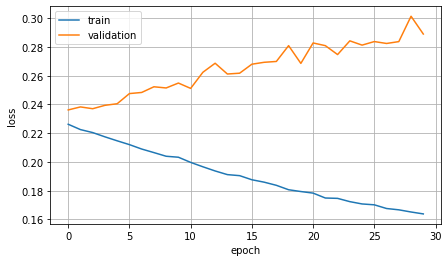

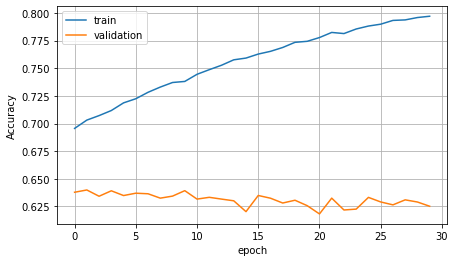

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

## **3.2 Bi-LSTM architecture**

In [ ]:
text_input=layers.Input(shape=(max_len_text,))
text_embedding = layers.Embedding(
    len(word_index_text)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_text),
    mask_zero=True,trainable=False,
    input_length=max_len_text)(text_input)
sentiment_input=layers.Input(shape=(max_len_sentiment,))
sentiment_embedding = layers.Embedding(
    len(word_index_sentiment)+1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sentiment),
    mask_zero=True,trainable=False,
    input_length=max_len_sentiment)(sentiment_input)
con=layers.Concatenate(axis=1)([text_embedding,sentiment_embedding])
bi_lstm=layers.Bidirectional(LSTM(16,return_sequences=True))(con) #bi-lstm

d = layers.Dense(8,activation="relu")(bi_lstm)
d = layers.Dropout(0.3)(d)
d = layers.Dense(4,activation="relu")(d)
output=layers.Dense(1,activation='sigmoid')(d)

model2=keras.Model(inputs=[text_input,sentiment_input],outputs=[output])

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model2.compile(loss=loss, optimizer=optim, metrics=metrics)

history=model2.fit([train_text,train_sentiment],y_train,epochs=15,batch_size=128,\
                  validation_data=([valid_text,valid_sentiment],y_valid),verbose=1)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


KeyboardInterrupt: ignored

Visualization

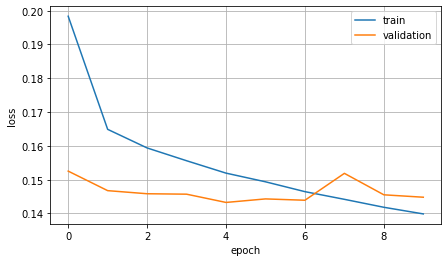

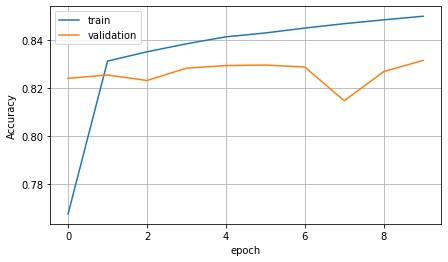

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

## **3.3 Models Comparison**

In [ ]:
#@title Helper function
def jaccard(str1,str2): 
    a=set(str1.lower().split()) 
    b=set(str2.lower().split())
    c=a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def get_index(pred):
    pred_index=[]
    for vector in pred:
      index=[]
      for i,value in enumerate(vector):
        if value == 1:
          index.append(i)
      pred_index.append(np.array(index))
    return pred_index
    
def get_text(x):
  selected_text=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      selected_text.append(text[i])
  return selected_text

LSTM

In [ ]:
pred_lstm = model1.predict([test_text,test_sentiment])
pred_lstm=np.round(np.squeeze(pred_lstm))

test_lstm = test.copy()[['textID','text','selected_text','sentiment']]
test_lstm['prediction']=get_index(pred_lstm)
test_lstm['pred_text']=test_lstm[['text','prediction']].apply(lambda x: get_text(x),axis=1)
test_lstm['pred_text']=test_lstm['pred_text'].apply(lambda x: ' '.join(x))

test_lstm['jaccard']=test_lstm.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)

print('Mean training Jaccard score:',np.mean(test_lstm['jaccard']))

Mean training Jaccard score: 0.553316060610876


Bi-LSTM

In [ ]:
pred_bi_lstm = model2.predict([test_text,test_sentiment])
pred_bi_lstm=np.round(np.squeeze(pred_bi_lstm))

test_bi_lstm = test.copy()[['textID','text','selected_text','sentiment']]
test_bi_lstm['prediction']=get_index(pred_bi_lstm)
test_bi_lstm['pred_text']=test_bi_lstm[['text','prediction']].apply(lambda x: get_text(x),axis=1)
test_bi_lstm['pred_text']=test_bi_lstm['pred_text'].apply(lambda x: ' '.join(x))

test_bi_lstm['jaccard']=test_bi_lstm.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)

print('Mean training Jaccard score:',np.mean(test_bi_lstm['jaccard']))

Mean training Jaccard score: 0.5955218163330321


# 4.Sentiment Extraction using BERT and RoBERTa

## Installation

In [ ]:
print(data.head())

In [ ]:
# install transformers
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 36.4 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 49.4 MB/s 
     |████████████████████████████████| 6.6 MB 30.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Import

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification
from sklearn.metrics import jaccard_score
from tqdm import tqdm
from transformers import RobertaForTokenClassification, RobertaTokenizer
from sklearn.model_selection import train_test_split
import numpy as np

## pre-trained BERT model and tokenizer

In [ ]:
# drop start index and end index column from dataset
data = data.drop(columns=['start_index', 'end_index'])

In [ ]:
data_split = np.array_split(data, 4)
print(data_split[0].shape)

(6846, 5)


In [ ]:
data = data_split[0]
print(data.shape)

(6846, 5)


In [ ]:
X = data[['text','sentiment']]
y = data['selected_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Data Loader

In [ ]:
class OurDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    input_ids = self.encodings["input_ids"][idx]
    attention = self.encodings["attention_mask"][idx]
    labels = self.labels[idx]
    return input_ids.long(), attention.long(), labels
  def __len__(self):
    return len(self.labels)

In [ ]:
encodings = tokenizer(list(X_train['text']), text_pair=list(X_train['sentiment']), max_length=32, padding=True, truncation=True, return_tensors="pt")
test_encodings= tokenizer(list(X_test['text']), text_pair=list(X_test['sentiment']), max_length=32, padding=True, truncation=True,  return_tensors="pt")
y_encodings = tokenizer(list(y_train), max_length=32, padding=True, truncation=True, return_tensors="pt")
y_test_encodings = tokenizer(list(y_test), max_length=32, padding=True, truncation=True, return_tensors="pt")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Selected text extract

In [ ]:
def map_selected_text(text_tensor, selected_text_tensor):
  selected = []
  
  for each in selected_text_tensor:
    if each ==101:
      continue
    if each ==102:
      break
    selected.append(each)
  pos = []
  # print(selected)
  for each in selected:
    pos.append((text_tensor == each).nonzero().flatten())
  ret = torch.zeros(text_tensor.shape[0])
  for each in pos:
    ret[each] = 1

  return ret


map_selected_text(encodings["input_ids"][1], y_encodings["input_ids"][1])
train_labels= []
test_labels = []

for i in range(len(encodings["input_ids"])):
  train_labels.append(map_selected_text(encodings["input_ids"][i], y_encodings["input_ids"][i]))

for i in range(len(test_encodings["input_ids"])):
  test_labels.append(map_selected_text(test_encodings["input_ids"][i], y_test_encodings["input_ids"][i]))

## 4.1 BERT Architecture and Evaluation

In [ ]:
train_labels = torch.stack(train_labels).long()
test_labels = torch.stack(test_labels).long()

In [ ]:
train_dataset = OurDataset(encodings, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
test_dataset = OurDataset(test_encodings, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=64, shuffle=False)

optim = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
def evaluate(model,val_dataloader):
  batch_score = []
  batch_loss = []
  with torch.no_grad():
    for batch in val_dataloader:
      inputs = batch[0]
      attention = batch[1]
      labels = batch[2]
      outputs = model(inputs, attention_mask = attention, labels=labels)
      logits = outputs.logits
      loss = outputs.loss
      preds = torch.argmax(logits, dim=2)
      score = []
      
      for i in range(len(labels)):
        score.append(jaccard_score(labels[i],preds[i]))
      batch_score.append(np.sum(score)/len(score))
      batch_loss.append(loss)


  return np.sum(batch_score)/len(batch_score), np.sum(batch_loss)/len(batch_loss)

In [ ]:
model.train()

for epoch in tqdm(range(3)):
  batch_loss = 0
  count=0
  for batch in tqdm(train_dataloader):
    optim.zero_grad()
    inputs = batch[0]
    attention = batch[1]
    labels = batch[2]
    outputs = model(inputs, attention_mask = attention, labels=labels)
    loss= outputs.loss
    loss.backward()
    optim.step()
    count+=1
    batch_loss += loss.item()
  print("Loss: ", batch_loss/count)
  val_score, val_loss = evaluate(model,test_dataloader)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)


100%|██████████| 75/75 [22:11<00:00, 17.75s/it]


Loss:  0.31591180006663006


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|███▎      | 1/3 [25:14<50:29, 1514.91s/it]

Validation Loss:  0.18921947479248047
Validation Jaccard Score:  0.48732834200797004



100%|██████████| 75/75 [22:09<00:00, 17.73s/it]


Loss:  0.17159997403621674


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|██████▋   | 2/3 [50:32<25:16, 1516.73s/it]

Validation Loss:  0.17222631338870886
Validation Jaccard Score:  0.5806376112689436



100%|██████████| 75/75 [22:18<00:00, 17.85s/it]


Loss:  0.1592425079147021


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 3/3 [1:15:44<00:00, 1514.24s/it]

In [ ]:
import os
os.makedirs("/content/trained_model")
model.save_pretrained("/content/trained_model")
!zip -r /content/model.zip /content/trained_model

from google.colab import files
files.download("/content/model.zip")

In [ ]:
val_score, val_loss = evaluate(model,test_dataloader)
print("Validation Loss: ", val_loss)
print("Validation Jaccard Score: ", val_score)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss:  0.16753120133371063
Validation Jaccard Score:  0.6178570029779169


## Pre-trained RoBERTa model and tokenizer

In [ ]:
roberta_model = RobertaForTokenClassification.from_pretrained("roberta-base")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
encodings2 = roberta_tokenizer(list(X_train['text']), text_pair=list(X_train['sentiment']), max_length=32, padding=True, truncation=True, return_tensors="pt")
test_encodings2 = roberta_tokenizer(list(X_test['text']), text_pair=list(X_test['sentiment']), max_length=32, padding=True, truncation=True,  return_tensors="pt")
y_encodings2 = roberta_tokenizer(list(y_train), max_length=32, padding=True, truncation=True, return_tensors="pt")
y_test_encodings2 = roberta_tokenizer(list(y_test), max_length=32, padding=True, truncation=True, return_tensors="pt")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [ ]:
def map_selected_text(text_tensor, selected_text_tensor):
  selected = []
  
  for each in selected_text_tensor:
    if each ==101:
      continue
    if each ==102:
      break
    selected.append(each)
  pos = []
  # print(selected)
  for each in selected:
    pos.append((text_tensor == each).nonzero().flatten())
  ret = torch.zeros(text_tensor.shape[0])
  for each in pos:
    ret[each] = 1

  return ret


map_selected_text(encodings2["input_ids"][1], y_encodings2["input_ids"][1])
train_labels2 = []
test_labels2 = []

for i in range(len(encodings2["input_ids"])):
  train_labels2.append(map_selected_text(encodings2["input_ids"][i], y_encodings2["input_ids"][i]))

for i in range(len(test_encodings["input_ids"])):
  test_labels2.append(map_selected_text(test_encodings2["input_ids"][i], y_test_encodings2["input_ids"][i]))

In [ ]:
train_labels2 = torch.stack(train_labels2).long()
test_labels2 = torch.stack(test_labels2).long()

In [ ]:
train_dataset2 = OurDataset(encodings2, train_labels2)
train_dataloader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_dataset2 = OurDataset(test_encodings2, test_labels2)
test_dataloader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=64, shuffle=False)

optim2 = torch.optim.AdamW(roberta_model.parameters(), lr=1e-5)

## 4.2 RoBERTa Architecture and Evaluation

In [ ]:
roberta_model.train()

for epoch in tqdm(range(3)):
  batch_loss = 0
  count=0
  for batch in tqdm(train_dataloader2):
    optim2.zero_grad()
    inputs = batch[0]
    attention = batch[1]
    labels = batch[2]
    outputs = roberta_model(inputs, attention_mask = attention, labels=labels)
    loss = outputs.loss
    loss.backward()
    optim2.step()
    count += 1
    batch_loss += loss.item()
  print("Loss: ", batch_loss/count)
  val_score, val_loss = evaluate(roberta_model,test_dataloader2)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)

100%|██████████| 75/75 [21:38<00:00, 17.32s/it]


Loss:  0.4199302005767822


 33%|███▎      | 1/3 [24:35<49:11, 1475.60s/it]

Validation Loss:  0.3483509583906694
Validation Jaccard Score:  0.72183036739435



100%|██████████| 75/75 [22:13<00:00, 17.78s/it]


Loss:  0.2739994251728058


 67%|██████▋   | 2/3 [49:50<24:58, 1498.93s/it]

Validation Loss:  0.22490169062758936
Validation Jaccard Score:  0.8787439355596516



100%|██████████| 75/75 [22:45<00:00, 18.21s/it]


Loss:  0.21279972652594248


100%|██████████| 3/3 [1:15:42<00:00, 1522.99s/it]

In [ ]:
import os
# os.makedirs("/content/trained_roberta_model")
model.save_pretrained("/content/trained_roberta_model")
!zip -r /content/trained_roberta_model.zip /content/trained_roberta_model

from google.colab import files
files.download("/content/roberta_model.zip")

In [ ]:
  val_score, val_loss = evaluate(roberta_model,test_dataloader2)
  print("Validation Loss: ", val_loss)
  print("Validation Jaccard Score: ", val_score)

Validation Loss:  0.21435484741673325
Validation Jaccard Score:  0.8809196669484296
